## Assignment by Vijay Singh Purohit   
$Department$ : $ Data Science $

$Roll Number$ : $DS7A-2016$


# Titanic 

Goal: predict survival on the Titanic  

Here we are looking into how to apply $Logistic Regression$ to the Titanic dataset.

# 1. Collect and understand the data

In [1]:
import pandas as pd

In [3]:
# get titanic training file as a DataFrame
titanic = pd.read_csv("../datasets/logistic/Titanic-train.csv")

In [4]:
titanic.shape

(891, 12)

In [5]:
# preview the data
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Variable Description
---
Survived: Survived (1) or died (0);  this is the target variable  
Pclass: Passenger's class (1st, 2nd or 3rd class)    
Name: Passenger's name  
Sex: Passenger's sex  
Age: Passenger's age  
SibSp: Number of siblings/spouses aboard  
Parch: Number of parents/children aboard  
Ticket: Ticket number  
Fare: Fare  
Cabin: Cabin  
Embarked: Port of embarkation

In [6]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Not all features are numeric:

In [7]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 2. Process the Data
Categorical variables need to be transformed into numeric variables

### Transform the embarkment port

There are three ports: C = Cherbourg, Q = Queenstown, S = Southampton

In [8]:
ports = pd.get_dummies(titanic.Embarked , prefix='Embarked')
ports.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


Now the feature Embarked (a category) has been trasformed into 3 binary features, e.g. Embarked_C = 0 not embarked in Cherbourg, 1 = embarked in Cherbourg.  
Finally, the 3 new binary features substitute the original one in the data frame:

In [9]:
titanic = titanic.join(ports)
titanic.drop(['Embarked'], axis=1, inplace=True) # then drop the original column

### Transform the gender feature
This transformation is easier, being already a binary classification (male or female, this was 1912).
It doesn't need to create separate dummy categories, a mapping will be enough:

In [10]:
titanic.Sex = titanic.Sex.map({'male':0, 'female':1})

## Extract the target variable
Create an X dataframe with the input features and an y series with the target (Survived)

In [11]:
y = titanic.Survived.copy() # copy “y” column values out

In [12]:
X = titanic.drop(['Survived'], axis=1) # then, drop y column

### Drop not so important features
For the first model, we ignore some categorical features which will not add too much of a signal.

In [13]:
X.drop(['Cabin'], axis=1, inplace=True) 

In [14]:
X.drop(['Ticket'], axis=1, inplace=True) 

In [15]:
X.drop(['Name'], axis=1, inplace=True) 
X.drop(['PassengerId'], axis=1, inplace=True)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Pclass        891 non-null int64
Sex           891 non-null int64
Age           714 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(2), int64(4), uint8(3)
memory usage: 44.5 KB


All features are now numeric, ready for regression.  
But we have still a couple of processing to do.

## Check if there are any missing values

In [17]:
X.isnull().values.any()

True

In [19]:
X[pd.isnull(X).any(axis=1)]  # check which rows have NaNs

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
5,3,0,NaN,0,0,8.4583,0,1,0
17,2,0,NaN,0,0,13.0000,0,0,1
19,3,1,NaN,0,0,7.2250,1,0,0
26,3,0,NaN,0,0,7.2250,1,0,0
28,3,1,NaN,0,0,7.8792,0,1,0
...,...,...,...,...,...,...,...,...,...
859,3,0,NaN,0,0,7.2292,1,0,0
863,3,1,NaN,8,2,69.5500,0,0,1
868,3,0,NaN,0,0,9.5000,0,0,1
878,3,0,NaN,0,0,7.8958,0,0,1


True, there are missing values in the data (NaN) and a quick look at the data reveals that they are all in the Age feature.  
One possibility could be to remove the feature, another one is to fill the missing value with a fixed number or the average age.

In [20]:
X.Age.fillna(X.Age.mean(), inplace=True)  # replace NaN with average age

In [21]:
X.isnull().values.any()

False

Now all missing values have been removed.  
The logistic regression would otherwise not work with missing values.

## Split the dataset into training and validation

The **training** set will be used to build the machine learning models. The model will be based on the features like passengers’ gender and class but also on the known survived flag.

The **validation** set should be used to see how well the model performs on unseen data. For each passenger in the test set, I use the model trained to predict whether or not they survived the sinking of the Titanic, then will be compared with the actual survival flag.

In [22]:
from sklearn.model_selection import train_test_split
  # 80 % go into the training test, 20% in the validation test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

# 3. Modelling

## Removing outliers

In [31]:
from scipy import stats

In [32]:
print("skewnees of data",stats.skew(X))

skewnees of data [-0.62948588  0.61787841  0.43375629  3.68912768  2.74448674  4.77925329
  1.59246242  2.94381099 -0.99540335]


In [33]:
print("kurtosis of data ", stats.kurtosis(X))

kurtosis of data  [-1.27956968 -1.61822627  0.95413892 17.77351175  9.71661324 33.20428925
  0.53593657  6.66602317 -1.00917218]


In [36]:
import numpy as np
import pandas as pd
xdf = pd.DataFrame(X)
zscore = np.abs(stats.zscore(xdf))
print(zscore)

[[0.82737724 0.73769513 0.5924806  ... 0.48204268 0.30756234 0.61930636]
 [1.56610693 1.35557354 0.63878901 ... 2.0745051  0.30756234 1.61470971]
 [0.82737724 1.35557354 0.2846632  ... 0.48204268 0.30756234 0.61930636]
 ...
 [0.82737724 1.35557354 0.         ... 0.48204268 0.30756234 0.61930636]
 [1.56610693 0.73769513 0.2846632  ... 2.0745051  0.30756234 1.61470971]
 [0.82737724 0.73769513 0.17706291 ... 0.48204268 3.25137334 1.61470971]]


In [37]:
outlierlist = np.where(zscore>3)

In [38]:
outlierlist

(array([  5,  13,  16,  16,  22,  25,  27,  28,  32,  44,  46,  47,  50,
         59,  68,  71,  82,  86,  88,  96, 109, 116, 116, 118, 119, 126,
        143, 156, 159, 164, 167, 171, 171, 180, 182, 186, 188, 196, 198,
        201, 208, 214, 233, 241, 245, 258, 260, 261, 264, 266, 274, 278,
        278, 280, 289, 299, 300, 301, 303, 311, 322, 324, 330, 341, 358,
        359, 360, 364, 368, 377, 380, 386, 388, 411, 412, 421, 428, 437,
        438, 438, 459, 468, 480, 493, 501, 502, 510, 517, 525, 527, 541,
        542, 552, 557, 560, 567, 573, 593, 610, 612, 613, 626, 629, 630,
        638, 653, 654, 657, 672, 678, 679, 680, 683, 686, 689, 697, 700,
        703, 716, 718, 727, 730, 736, 737, 742, 745, 749, 767, 768, 774,
        776, 778, 779, 787, 787, 790, 792, 813, 824, 825, 828, 846, 850,
        851, 858, 863, 885, 885, 890], dtype=int64),
 array([7, 4, 3, 7, 7, 4, 5, 7, 7, 7, 7, 7, 3, 3, 3, 3, 7, 4, 5, 2, 7, 2,
        7, 5, 3, 7, 7, 7, 3, 3, 4, 3, 7, 3, 3, 7, 7, 7, 7, 3, 7, 7, 3,

In [39]:
final = outlierlist[0]

In [41]:
new_xdf = xdf.drop(index=final)
ydf = pd.DataFrame(y)
new_ydf = ydf.drop(index=final)

In [42]:
x_train_new,x_test_new,y_train_new,y_test_new = train_test_split(new_xdf,new_ydf)

In [44]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()

In [45]:
model1.fit(x_train_new, y_train_new)

C:\Users\Vijay Purohit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Vijay Purohit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

##  Logistic Regression

Will use a simple logistic regression, that takes all the features in X and creates a regression line.
This is done using the LogisticRegression module in SciKitLearn.

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [24]:
model.fit(X_train, y_train)

C:\Users\Vijay Purohit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# 4. Evaluate the model

## Test Model which usages Outliers 

In [46]:
model1.score(X_train, y_train)

0.7935393258426966

In [48]:
model1.score(X_valid, y_valid)

0.7541899441340782

## Test Model Without Outliers

In [25]:
model.score(X_train, y_train)

0.8103932584269663

In [26]:
model.score(X_valid, y_valid)

0.7597765363128491

Two things:
- the score on the training set is much better than on the validation set, an indication that could be overfitting and not being a general model, e.g. for all ship sinks.
- the score on the validation set is quite better, so it adds some value at a minimal cost.

In [27]:
model.intercept_ # the fitted intercept

array([1.42242589])

In [28]:
model.coef_  # the fitted coefficients

array([[-9.31919223e-01,  2.83123062e+00, -3.92725786e-02,
        -3.92811222e-01,  1.93182310e-02,  1.90387322e-03,
         7.44068132e-01,  4.55523778e-01,  2.22833985e-01]])

The correlation matrix may give us a understanding of which variables are important

In [29]:
titanic.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.036847,-0.057527,-0.001652,0.012658,-0.001205,-0.033606,0.022148
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,0.168240,0.003650,-0.155660
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,-0.243292,0.221009,0.081720
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,0.082853,0.074115,-0.125722
Age,0.036847,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,0.036261,-0.022405,-0.032523
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,-0.059528,-0.026354,0.070941
Parch,-0.001652,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,-0.011069,-0.081228,0.063036
Fare,0.012658,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,0.269335,-0.117216,-0.166603
Embarked_C,-0.001205,0.168240,-0.243292,0.082853,0.036261,-0.059528,-0.011069,0.269335,1.000000,-0.148258,-0.778359
Embarked_Q,-0.033606,0.003650,0.221009,0.074115,-0.022405,-0.026354,-0.081228,-0.117216,-0.148258,1.000000,-0.496624


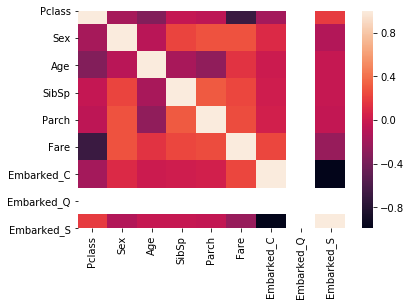

In [52]:
import seaborn
seaborn.heatmap(data=new_xdf.corr())

In [ ]:
import seaborn
seaborn.heatmap(data=xdf_new2.corr())

The resulting score is **0.75119**  
Note that the score on the validation set has been a good predictor!

# Thank you